# Determine redshift using machine learning

First, what is redshift and why is it important? Redshift is the equivalent to the distance of stellar objects from us. It is measured using spectroscopy. It is measured by calculating the shift of the spectra, which is a graph that shows how much light is emitted or absorbed at each wavelength,to the red side of the wavelength spectrum (hence redshift). The method used is to compare the spectra of the source to what the spectra should be at if the stellar objects was right next to us. They use emision lines of known elements to make  hypothetical spectra of objects at redshift 0. Different types of objects have different shape of the spectra and objects within a class share similar characteristics. The stellar objects are shifted to the red because they are moving away from us due to the expansion of the universe. This is important because it allow us also to calculate the actual magnitudes of the stellar objects and we can do a lot of fun science with it. The amount of spectra data is not up to par with the vastamount of optical data available so it is important to have good redshifts obtained from photometry.

The data was obtained using the skyserver from the Sloan Digital Sky Survey (SDSS) using the SQL query. I did most of the data engineering in the query. I specified for no missing values of the redshift also for it to be positive (there are negative redshift which means they are moving towards us and that they are in our local area). I removed negative redshift because it interfers whith the workings of the Random Forest Regressor. I also made sure errors were between 0.0 and 0.1.For the five bands (u,g,r,i,z) I selected the dered values from the table to  account for galactic extinction. There maybe a confusion between z the band and z the redshift but in this study the band will always be denoted with dered_z. I also contrained the errors on the magnitued to be less than 0.1. The SQL script used in the [CasJobs website](https://skyserver.sdss.org/casjobs/) can be seen in the file "sql_skyserver_sdss.odt" in the script_notebooks folder of this project.

To note that SDSS removed their photozRF table because it does poorly with the faint red galaxies targeted in  Baryon Oscillation Spectroscopic Survey (BOSS). 


In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline

## Loading data and some EDA

In [2]:
#loading files
filepath= "/home/veroastro/Documents/spectraTypes/MLphotometry/data/"
galaxy = pd.read_csv(filepath+"galaxy_rand5.csv")
star = pd.read_csv(filepath+"star_rand.csv")
QSO = pd.read_csv(filepath+"QSO_rand.csv")
print(f'Number of data points in the star dataframe {star["z"].count()}')
print(f'Number of data points in the OSO dataframe {QSO["z"].count()}')
print(f'Number of data points in the galaxy dataframe {galaxy["z"].count()}')

Number of data points in the star dataframe 3671
Number of data points in the OSO dataframe 5000
Number of data points in the galaxy dataframe 5000


The combined dataset will be imbalance towards stars. The SQL script is the same for all classes but for some reason the obtained star dataset is smaller than the QSO and galaxy datasets.

In [3]:
#Create the data frame from the three sets of data
data = pd.concat([star, QSO, galaxy])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data = data.sample(frac=1)

data.describe()

,objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,z,zErr,zWarning,photoZ,photoErr
count,1.367100e+04,13671.0,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,1.367100e+04,1.367100e+04,13671.0,13671.000000,13671.000000
mean,1.237662e+18,3.0,19.123679,0.045883,17.910556,0.008961,17.236257,0.007668,16.870452,0.007990,16.628443,0.019476,1.458658e-01,3.688415e-05,0.0,-120.522102,-120.644692
std,6.681097e+12,0.0,1.112383,0.024062,1.220852,0.005342,1.296912,0.005429,1.318627,0.005813,1.307353,0.015810,2.567484e-01,3.514981e-04,0.0,1091.904157,1091.890600
min,1.237646e+18,3.0,6.673403,0.000013,9.884518,0.000220,9.321852,0.000260,9.242759,0.000210,9.800303,0.001093,7.937708e-09,1.071480e-08,0.0,-9999.000000,-9999.000000
25%,1.237658e+18,3.0,18.571080,0.026353,17.265860,0.005500,16.477270,0.004414,16.057380,0.004403,15.791895,0.008781,1.045076e-03,1.035503e-05,0.0,0.071305,0.015206
50%,1.237662e+18,3.0,19.270480,0.041928,17.991810,0.007669,17.242790,0.006048,16.860720,0.006163,16.611150,0.014512,9.544864e-02,2.023870e-05,0.0,0.119299,0.024038
75%,1.237666e+18,3.0,19.871815,0.063235,18.639680,0.010635,18.055465,0.009154,17.725690,0.009742,17.495920,0.025105,1.923601e-01,3.551534e-05,0.0,0.199105,0.037786
max,1.237681e+18,3.0,21.491850,0.099991,20.960650,0.067567,21.669820,0.096349,20.886630,0.089653,20.105530,0.099328,6.215998e+00,3.497584e-02,0.0,0.929950,0.277625


In [4]:
data_clean = data.drop(columns=['zWarning','objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass', 'photoZ','photoErr','type'])
data_clean.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
1570,19.33672,18.77274,18.18881,17.81488,17.72134,0.176473
187,19.04697,17.97093,17.61848,17.37490,17.27285,0.045134
1605,20.35099,19.43314,18.89454,18.78558,18.74810,0.000235
3755,21.15722,20.84122,20.55897,20.35065,19.62008,0.407330
2976,18.41461,17.89139,17.12608,16.66057,16.46144,0.162439


In [5]:
data_clean.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
count,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,1.367100e+04
mean,19.123679,17.910556,17.236257,16.870452,16.628443,1.458658e-01
std,1.112383,1.220852,1.296912,1.318627,1.307353,2.567484e-01
min,6.673403,9.884518,9.321852,9.242759,9.800303,7.937708e-09
25%,18.571080,17.265860,16.477270,16.057380,15.791895,1.045076e-03
50%,19.270480,17.991810,17.242790,16.860720,16.611150,9.544864e-02
75%,19.871815,18.639680,18.055465,17.725690,17.495920,1.923601e-01
max,21.491850,20.960650,21.669820,20.886630,20.105530,6.215998e+00


In [6]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
            # Making it pretty with frame and grid
            ax.spines['top'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['top'].set_linewidth(1)
            ax.spines['right'].set_linewidth(1)
            ax.spines['bottom'].set_linewidth(1)
            ax.spines['left'].set_linewidth(1)
            ax.grid(color='b', linestyle='-', linewidth=0.5)
            ax.set_facecolor('xkcd:white')
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

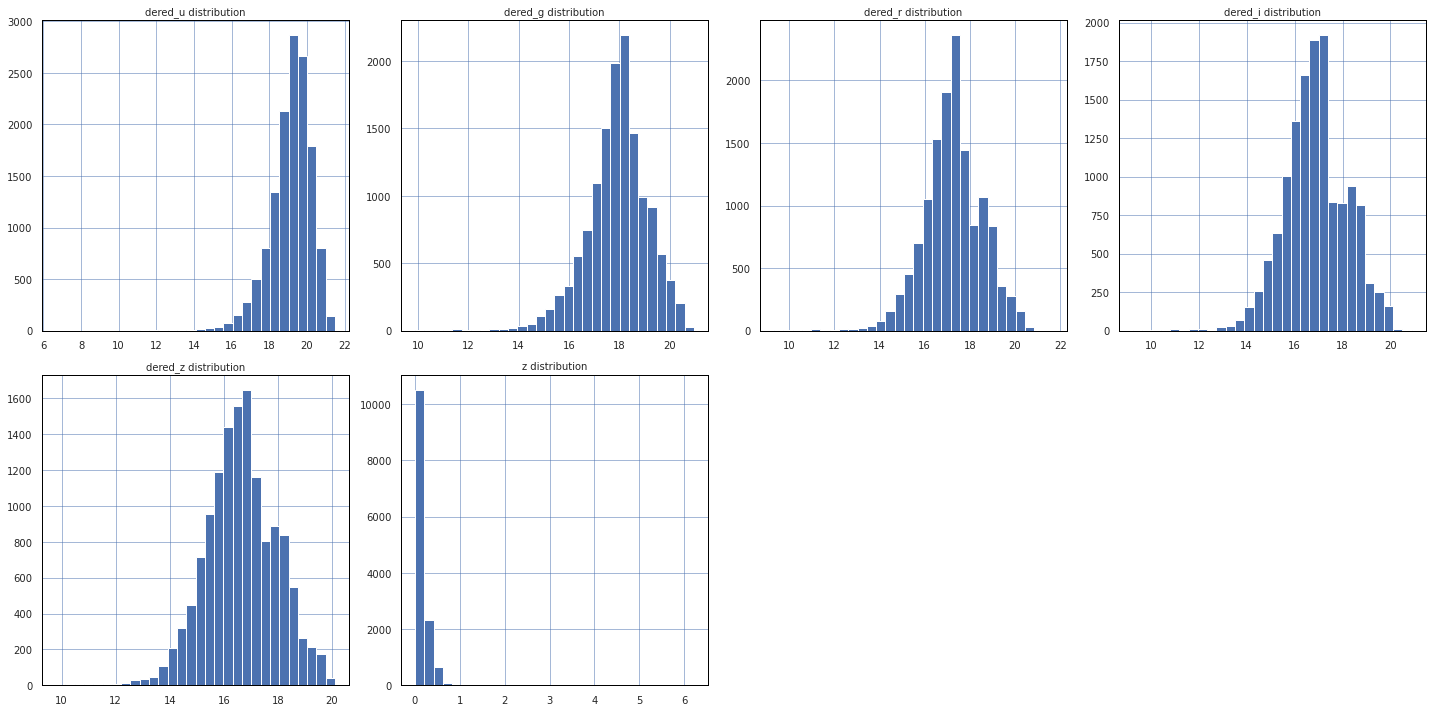

In [7]:
hist_plots(data=data_clean,
          rows=2,
          cols=4,
          figsize=(20,10))
#plt.savefig(filepath+'images/zhistplot.png')

The magnitudes of the bands are in the interquartile ranges (25-75%) between 16-18. The fainter (higher value) sources are mostly outliers of the destributions. Since the distributions are fairly bright, I decided to keep them.

## Looking at Redshifts

The columns of photoZ and photoErr refer to the redshift determined using only photometric(the magnitudes in the 5 SDSS bands) data. This was done using a kd-tree nearest neighbor fit (KF). There is more information on [photoZ page](https://www.sdss4.org/dr16/algorithms/photo-z/). While the columns z and zERR refer to the spectroscopic redshifts obtained by comparing the spectra obtained with the assumed spectra at redshift 0. 

Text(0.5, 1.0, 'Redshif and PhotoZ Histograms')

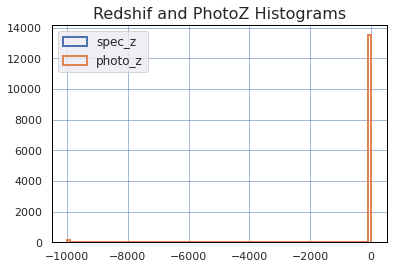

In [8]:
bins= 100
ax = plt.subplot(111)
ax.hist(data['z'] , bins,histtype='step', linewidth=2,label='spec_z')
ax.hist(data['photoZ'] , bins,histtype='step', linewidth=2, label='photo_z')
# Making it pretty with frame and grid
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.grid(color='b', linestyle='-', linewidth=0.5)
ax.set_facecolor('xkcd:white')
#set legend, lables and title
ax.legend(loc='upper left',fontsize=12)
#plt.set_xlabel(n)
ax.set_title('Redshif and PhotoZ Histograms', fontsize=16)

The distribution of the photometric redshift ranges from -10000 to positive numbers. In these cases, the photometric reshift werent able to determine the actual values of the redshift. The known values of redshift range from 0 up to around 11. The vast majority of objects with known redshifts have values between 0 and 7.

Removing 165 objects with negative values of photoZ


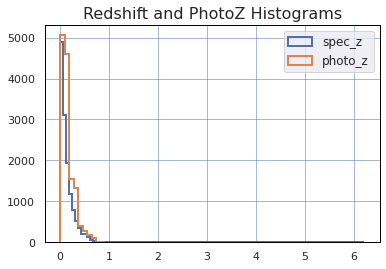

In [9]:
p_photoZ =data.loc[(data['photoZ'] >= 0.0)]['photoZ']
specZ = data['z']
p_specZ = data.loc[(data['photoZ'] >= 0.0)]['z']
print(f'Removing {specZ.count() - p_photoZ.count()} objects with negative values of photoZ' )

ax = plt.subplot(111)
#Plotting the two distributions of redshift
ax.hist(p_specZ , bins = 100,  histtype='step', linewidth=2,label='spec_z')
ax.hist(p_photoZ , histtype='step', linewidth=2, label='photo_z')
# Making it pretty with frame and grid
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.grid(color='b', linestyle='-', linewidth=0.5)
ax.set_facecolor('xkcd:white')
#set legend, lables and title
ax.legend(loc='upper right',fontsize=12)
#plt.set_xlabel(n)
ax.set_title('Redshift and PhotoZ Histograms', fontsize=16)
plt.show()

Both distributions are similar within the range of 0-0.8. The reason for choosing 2 different number of bins is that the  range of values in redshift differ from each other. The photometric redshift (eliminating negative values) ranges from 0-0.8 while the range of spectroscopic redshift is of 0 - 6 but the main area of the redshift is between 0- 0.8 with a long tail. This means that for these objects with redshift more than 0.8, the photometric redshift determines them with lower values of redshift. This means that we are sampling shorter redshift.

In [10]:
# Defining the photometric redshifht error for objects with positive fotometric redshifts
photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoErr']
print('Mean photoError:', round(np.mean(photozErr), 5))

Mean photoError: 0.03713


In [11]:
# Defining the redshift error for objects with positive fotometric redshifts
speczErr= data.loc[(data['photoZ'] >= 0.0)]['zErr']
print('Mean specError:', round(np.mean(speczErr), 5))

Mean specError: 4e-05


The mean photometric redshift error is aproximately three orders of magnitudes between the mean values of spectroscopic and photometric redshift error.

## Sampling without photoZ values

In the histogram before, the values of redshift sample mainly the population of objects with redshifts between 0-0.8. This bias may affect mostly galaxies and QSOs In this section, I check if by constraining the data to have also photoZ values, contrains the range of redshifts sampled. I use the same method and sql script as the original data but remove the values of photoZ and photoErr and with that also the inner join to the PhotoZ table.

In [12]:
new_galaxy = pd.read_csv(filepath+"galaxy_nophotoZ4.csv")
new_star = pd.read_csv(filepath+"star_nophotoZ.csv")
new_QSO = pd.read_csv(filepath+"QSO_nophotoZ.csv")
#Create the data frame from the three sets of data
data_nophoto = pd.concat([new_star, new_QSO, new_galaxy])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data_nophoto = data_nophoto.sample(frac=1)
data_nophoto.describe()

,objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,z,zErr,zWarning
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,1.500000e+04,15000.0
mean,1.237663e+18,4.929000,19.278773,0.042984,18.242983,0.009593,17.803544,0.009490,17.590448,0.010945,17.445029,0.029899,5.338676e-01,1.237876e-04,0.0
std,7.483467e+12,1.437392,1.073886,0.023426,1.280207,0.005298,1.444430,0.006185,1.521226,0.007890,1.569711,0.025342,8.067329e-01,3.004838e-04,0.0
min,1.237646e+18,3.000000,7.552934,0.003263,7.661058,0.000773,8.319589,0.000540,10.746470,0.000361,8.741409,0.001826,5.417808e-09,2.446185e-07,0.0
25%,1.237658e+18,3.000000,18.716025,0.023869,17.467247,0.005797,16.804580,0.005041,16.486115,0.005232,16.265550,0.010507,3.022298e-04,1.047030e-05,0.0
50%,1.237662e+18,6.000000,19.425340,0.039461,18.242070,0.008259,17.639700,0.007119,17.365905,0.007650,17.256925,0.019170,8.968894e-02,2.082942e-05,0.0
75%,1.237667e+18,6.000000,20.037327,0.059336,19.222772,0.011863,19.024073,0.012156,18.929403,0.014503,18.864542,0.042937,9.271685e-01,1.645424e-04,0.0
max,1.237681e+18,6.000000,21.546420,0.099982,22.145940,0.089225,21.324990,0.077705,21.340340,0.087281,20.616610,0.099979,6.164721e+00,2.278432e-02,0.0


In [13]:
print(f'Number of data points in the star dataframe {new_star["z"].count()}')
print(f'Number of data points in the OSO dataframe {new_QSO["z"].count()}')
print(f'Number of data points in the galaxy dataframe {new_galaxy["z"].count()}')

Number of data points in the star dataframe 5000
Number of data points in the OSO dataframe 5000
Number of data points in the galaxy dataframe 5000


Now the combine data set will be balance between the three classes. Maybe the discrepancy between the star datasets is because of the contraint of the photometric values. 

In [14]:
# converting class from categorical to numerical
def type_to_value(n):
    if n == 'STAR':
        return 1
    elif n == 'QSO':
        return 2
    elif n == 'GALAXY':
        return 3
    

data['nClass'] = [type_to_value(n) for n in data['class']]
data_nophoto['nClass'] = [type_to_value(n) for n in data_nophoto['class']]

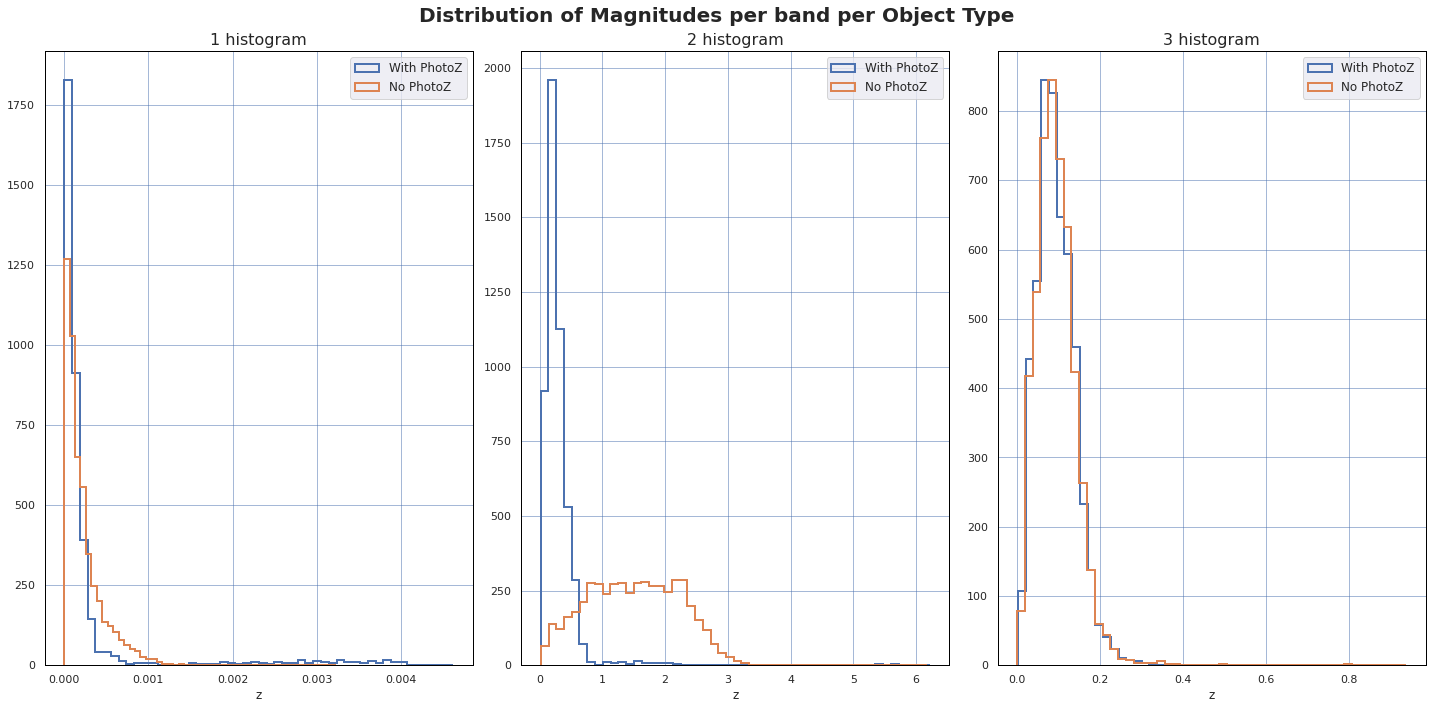

In [15]:
bins= 50

cols = [1, 2, 3]
fig,axs = plt.subplots(1,3, figsize=(20,10), edgecolor='black')
axs = axs.ravel()

for i, n in enumerate(cols):
    ax = axs[i]
    if i < len(cols):
        #create the histograms for the object type per band
        ax.hist(data[data['nClass']== n]['z'],bins= bins,histtype='step', linewidth=2,label='With PhotoZ')
        ax.hist(data_nophoto[data_nophoto['nClass']== n]['z'],bins= bins,histtype='step', linewidth=2, label='No PhotoZ')
        # Making it pretty with frame and grid
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        ax.grid(color='b', linestyle='-', linewidth=0.5)
        ax.set_facecolor('xkcd:white')
        #set legend, lables and title
        ax.legend(loc='upper right',fontsize=12)
        ax.set_xlabel('z')
        ax.set_title(f'{n} histogram', fontsize=16)
    else:
        fig.delaxes(ax=ax)
            
fig.suptitle('Distribution of Magnitudes per band per Object Type', fontsize=20, fontweight="bold")
fig.tight_layout()
plt.show()

Both distributions of spectroscopic redshifts (z) for the datasets with and without photometric redshift contraint are very similar for the class 1(star) and class 3(galaxy). For the class2(QSO), both distributions are quite different. The distribution of z for the dataset with photometric contraint have values mostly in the region between 0 and 1. While the distribution of z for the dataset without photometric contraint have values between 0 and 3. 

Because of this and the fact that without the photometric redshift contraint the  data set is balanced, I decided that for the building of the models to determine redshift I will use the dataset without photometric constraint.

## Prepping new dataset

In [16]:
data_cl = data_nophoto.drop(columns=['zWarning','objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass','type'])
data_cl.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2319,18.70122,18.31729,18.24332,18.30030,18.15168,0.754905,2
2890,20.20726,20.07798,19.88147,19.60539,19.84044,1.495903,2
448,20.12084,17.68555,16.76403,16.46831,16.33418,0.000144,1
1638,19.21249,17.35924,16.38363,15.84537,15.43789,0.086278,3
551,19.17308,17.90121,17.21264,16.82657,16.62209,0.158304,3


## Looking at magnitudes and colours for the data_nophoto 

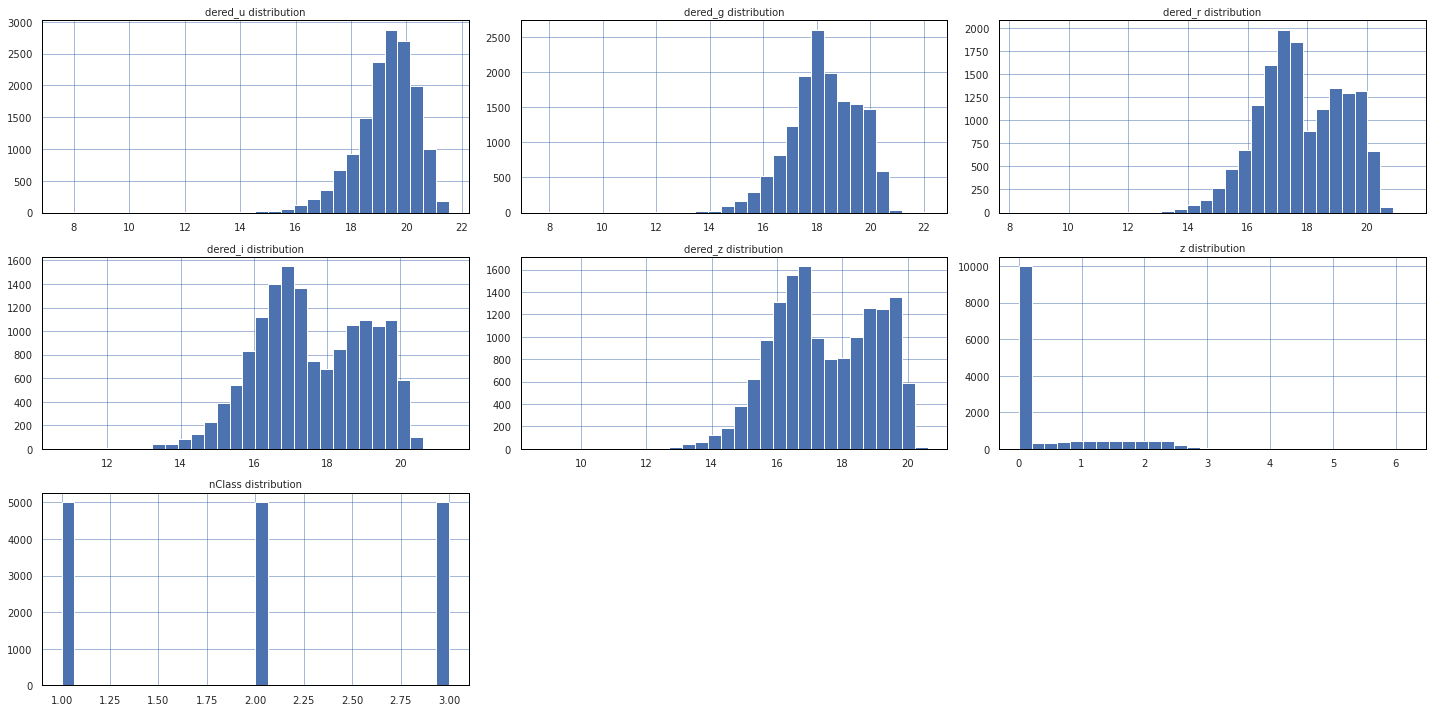

In [17]:
hist_plots(data=data_cl,
          rows=3,
          cols=3,
          figsize=(20,10))

The distribution of the magnitued per band doesn't have a gausian distribution. This could be due to the fact that I am combining three different populations.

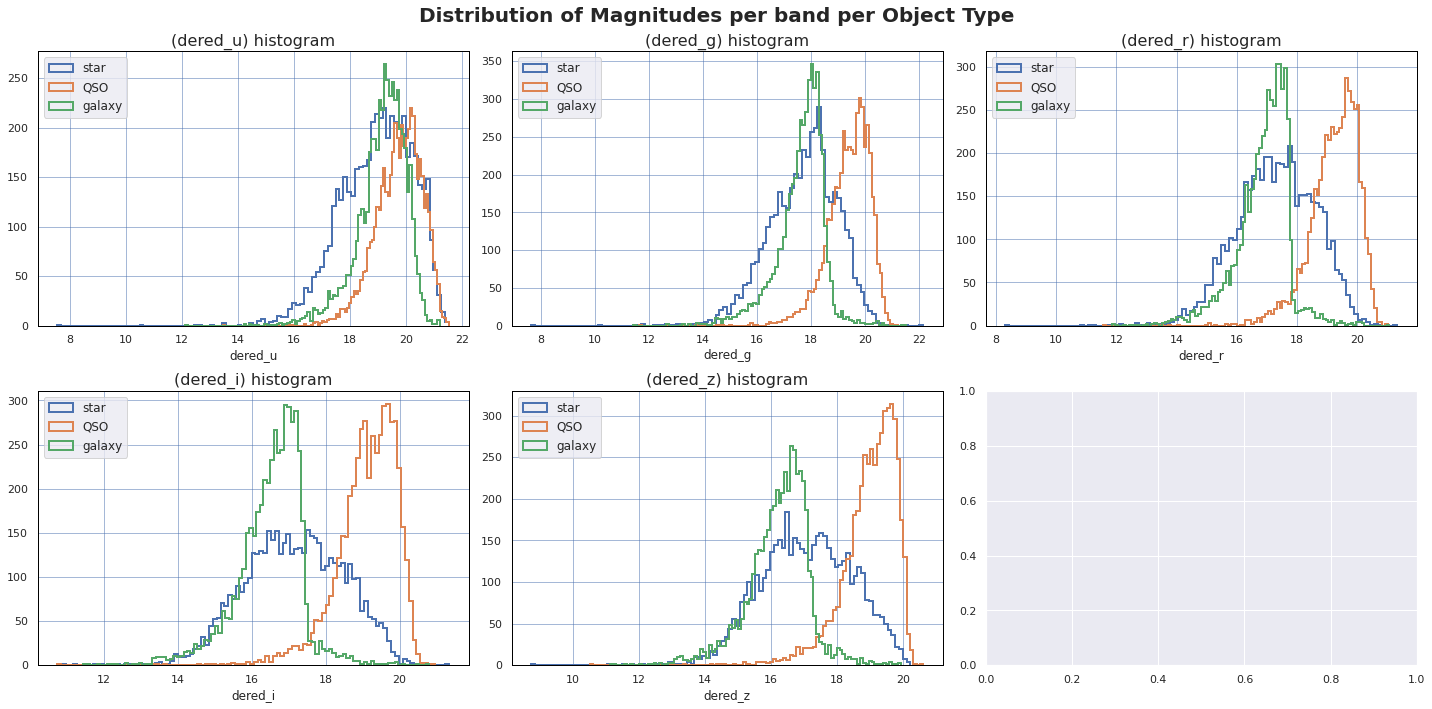

In [18]:
cols = ['dered_u','dered_g','dered_r','dered_i','dered_z']
bins= 100
# Create subplots and plot histograms
fig,axs = plt.subplots(2,3, figsize=(20,10), edgecolor='black')
axs = axs.ravel()
data.loc[(data['photoZ'] >= 0.0)]['photoErr']
for i, n in enumerate(cols):
    ax = axs[i]
    X = data_cl[n]
    if i < len(cols):
        #create the histograms for the object type per band
        ax.hist(X.loc[data_cl['nClass']==1], bins,histtype='step', linewidth=2,label='star')
        ax.hist(X.loc[data_cl['nClass']==2], bins,histtype='step', linewidth=2, label='QSO')
        ax.hist(X.loc[data_cl['nClass']==3], bins,histtype='step', linewidth=2, label='galaxy')
        # Making it pretty with frame and grid
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        ax.grid(color='b', linestyle='-', linewidth=0.5)
        ax.set_facecolor('xkcd:white')
        #set legend, lables and title
        ax.legend(loc='upper left',fontsize=12)
        ax.set_xlabel(n)
        ax.set_title(f'({n}) histogram', fontsize=16)
    else:
        fig.delaxes(ax=ax)
            
fig.suptitle('Distribution of Magnitudes per band per Object Type', fontsize=20, fontweight="bold")
fig.tight_layout()
plt.show()

The increasingly bimodal distribution of the magnitudes per band can be explained by the different populations in the dataset. I will use non-parametric learning algorithms.

In [19]:
# Create a function to calculate the colours of the sources
def compute_colour(row):
    u = row['dered_u']
    g = row['dered_g']
    r = row['dered_r']
    i = row['dered_i']
    z = row['dered_z']
    return pd.Series({'u-g': u - g, 'g-r': g - r, 'r-i': r - i, 'i-z': i - z})
# Apply the function compute_colour
colour_ind = data_cl.apply(compute_colour, axis=1)
# Create new dataframe with the colours added
data_colour = pd.concat([data_cl,colour_ind], axis=1)
data_colour.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass,u-g,g-r,r-i,i-z
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,19.278773,18.242983,17.803544,17.590448,17.445029,5.338676e-01,2.000000,1.035791,0.439438,0.213096,0.145420
std,1.073886,1.280207,1.444430,1.521226,1.569711,8.067329e-01,0.816524,0.647352,0.350960,0.196789,0.171565
min,7.552934,7.661058,8.319589,10.746470,8.741409,5.417808e-09,1.000000,-1.391450,-1.454840,-3.861471,-1.146380
25%,18.716025,17.467247,16.804580,16.486115,16.265550,3.022298e-04,1.000000,0.465475,0.174497,0.087350,0.027745
50%,19.425340,18.242070,17.639700,17.365905,17.256925,8.968894e-02,2.000000,1.048255,0.382455,0.202605,0.133620
75%,20.037327,19.222772,19.024073,18.929403,18.864542,9.271685e-01,3.000000,1.506298,0.715958,0.372275,0.273913
max,21.546420,22.145940,21.324990,21.340340,20.616610,6.164721e+00,3.000000,3.653620,3.852890,1.688770,3.762850


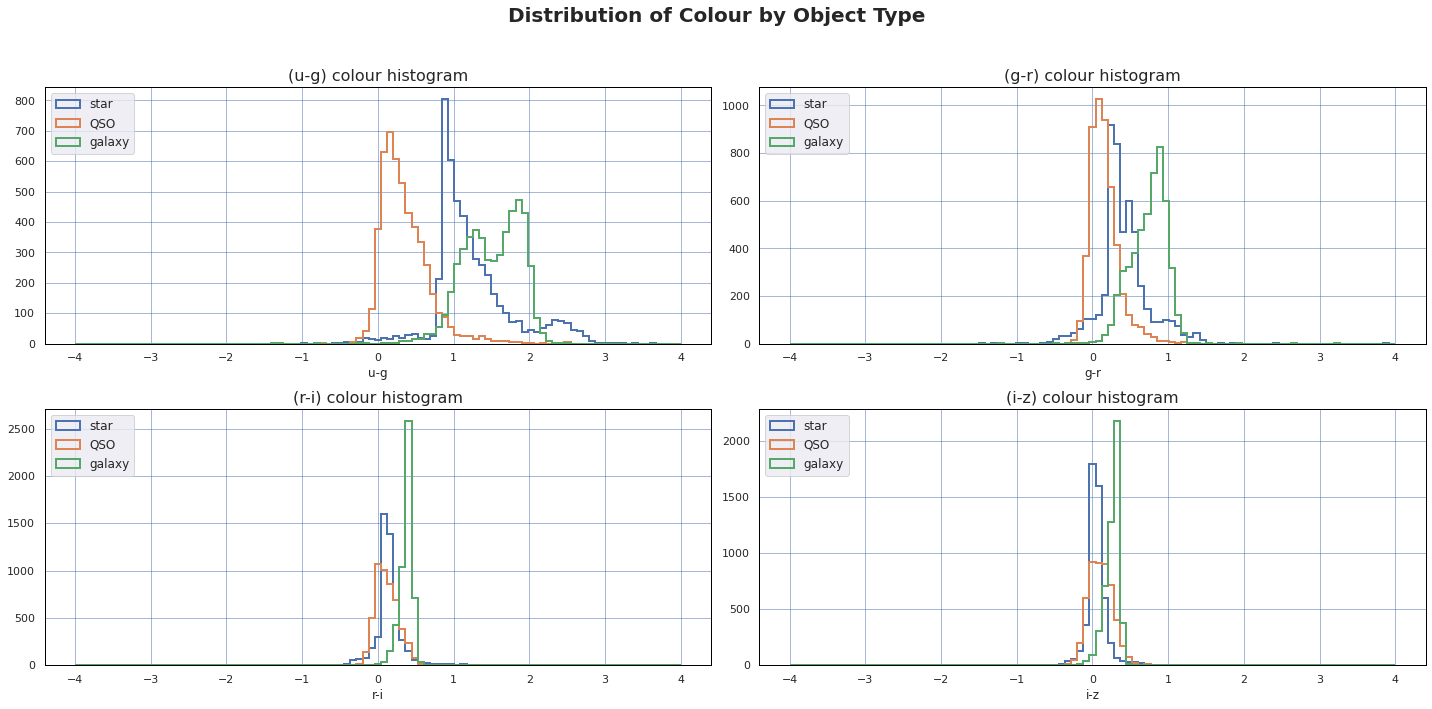

In [20]:
colour = ['u-g','g-r','r-i','i-z']

# Create subplots and plot histograms
bins = np.linspace(-4, 4, 100)
fig,axs = plt.subplots(2,2, figsize=(20,10), edgecolor='black')
axs = axs.ravel()

for i, n in enumerate(colour):
    ax = axs[i]
    X = data_colour[n]
    #create the histograms for the object type per colour
    ax.hist(X.loc[data_colour['nClass']==1], bins,histtype='step', linewidth=2,label='star')
    ax.hist(X.loc[data_colour['nClass']==2], bins,histtype='step', linewidth=2, label='QSO')
    ax.hist(X.loc[data_colour['nClass']==3], bins,histtype='step', linewidth=2, label='galaxy')
    # Making it pretty with frame and grid
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.grid(color='b', linestyle='-', linewidth=0.5)
    ax.set_facecolor('xkcd:white')
    #set legend, lables and title
    ax.legend(loc='upper left',fontsize=12)
    ax.set_xlabel(n)
    ax.set_title(f'({n}) colour histogram', fontsize=16)
    
fig.suptitle('Distribution of Colour by Object Type', fontsize=20, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

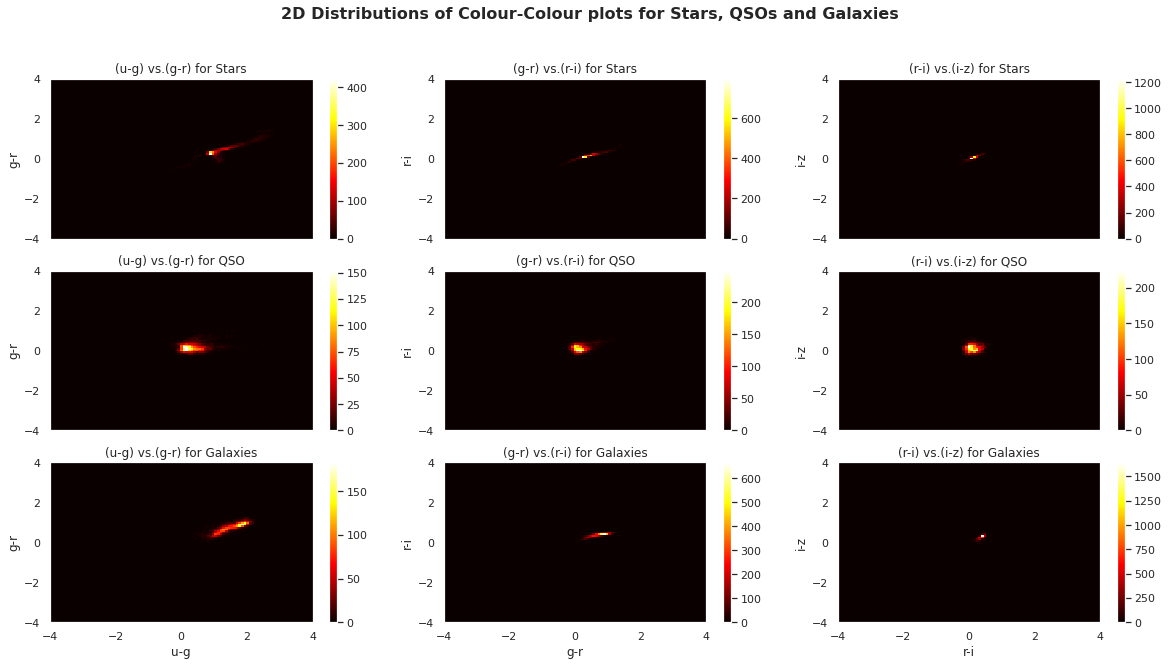

In [21]:
# Create 2D distributions for each colour vs colour for each object type
fig, axs = plt.subplots(3, 3, figsize=(20, 10), sharex='col')

bins = np.linspace(-4, 4, 100)

classes = [1, 2, 3]
objects = ['Stars', 'QSO', 'Galaxies']


for i in range(len(colour)-1):
    for j, n in enumerate(classes):
        
        h = axs[j, i].hist2d(data_colour.loc[data_colour['nClass']==n][colour[i]],
                         data_colour.loc[data_colour['nClass']==n][colour[i+1]], bins, cmap='hot')
        
        # Set labels for each subplot
        axs[j, i].set_title(f'({colour[i]}) vs.' f'({colour[i+1]}) for ' f'{objects[j]}')
        axs[j, i].set_ylabel(colour[i + 1])
        if j>= 2 :
                axs[j,i].set_xlabel(colour[i])
        
        # Add colorbars to each subplot
        fig.colorbar(h[3], ax=axs[j, i])    
            

fig.suptitle('2D Distributions of Colour-Colour plots for Stars, QSOs and Galaxies', 
             fontsize=16, fontweight="bold")

# Show the plot
plt.show()

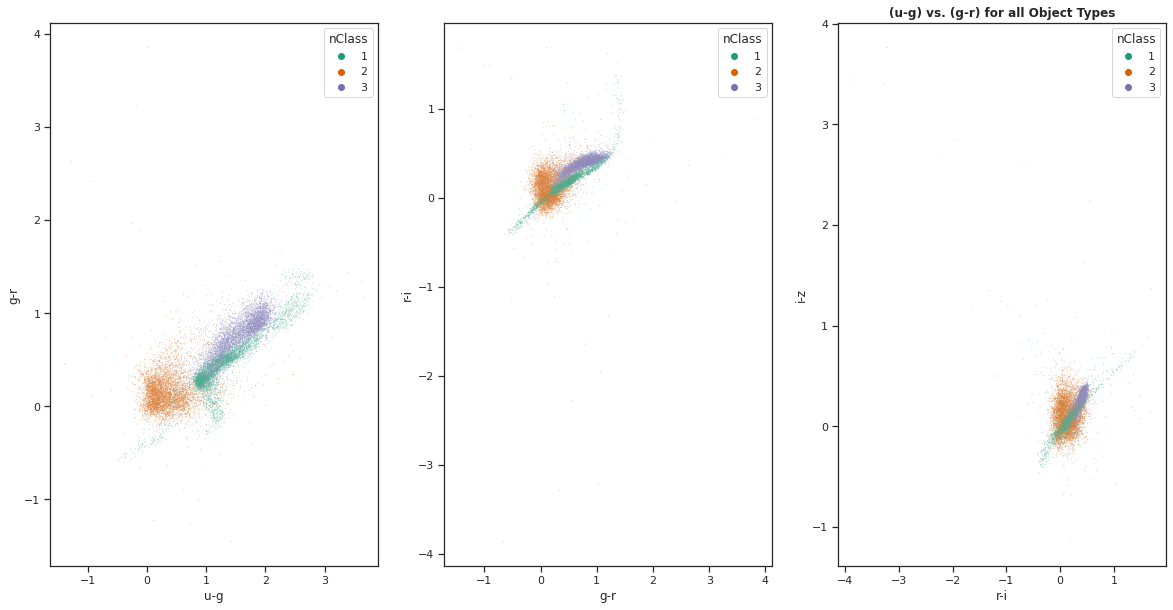

In [22]:
#Scatter plot hued by classes

sns.set_style("ticks")
  
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sns.scatterplot(ax= axs[0], x="u-g", y="g-r", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)
sns.scatterplot(ax= axs[1], x="g-r", y="r-i", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)
sns.scatterplot(ax= axs[2], x="r-i", y="i-z", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)

# Add title and legend
plt.title('(u-g) vs. (g-r) for all Object Types', fontweight="bold")
#plt.legend( objects,fontsize=10, loc='upper left')
#plt.savefig('/home/veroastro/Documents/spectraTypes/images/scatter_classes.pdf')
plt.show()

In [23]:
data_cl.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2319,18.70122,18.31729,18.24332,18.30030,18.15168,0.754905,2
2890,20.20726,20.07798,19.88147,19.60539,19.84044,1.495903,2
448,20.12084,17.68555,16.76403,16.46831,16.33418,0.000144,1
1638,19.21249,17.35924,16.38363,15.84537,15.43789,0.086278,3
551,19.17308,17.90121,17.21264,16.82657,16.62209,0.158304,3


## Preprocessing Data

In [24]:
# separating feature X and label y and scaling data without photoZ
from sklearn.preprocessing import RobustScaler
X = data_cl.drop(['nClass', 'z'], axis=1)
y = data_cl['z']
# Using RobustScaler to scale the dataset
scaler = RobustScaler()
X_t = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_t, columns = X.columns)

In [25]:
# separating feature X and label y and scaling data with photoZ
X_all = data_clean.drop([ 'z'], axis=1)
y_all = data_clean['z']
# Using RobustScaler to scale the dataset
X_all_t = scaler.fit_transform(X_all)
X_all_scaled = pd.DataFrame(X_all_t, columns = X.columns)

In [26]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {X_train["dered_u"].count()}')
print(f'Count of X_test = {X_test["dered_u"].count()}')

Count of X_train = 10500
Count of X_test = 4500


In [27]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all_scaled, y_all, test_size=0.3, random_state=42)

print(f'Count of X_train = {X_all_train["dered_u"].count()}')
print(f'Count of X_test = {X_all_test["dered_u"].count()}')

Count of X_train = 9569
Count of X_test = 4102


## Training Models

In [28]:
#training and predicting with Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#RF = RandomForestRegressor(oob_score=True, warm_start=True, random_state = 42)
#param_grid = {  'bootstrap': [True],
#                'max_features': ['log2','sqrt', None], 
#                'n_estimators': range(50,500, 20),
#                'criterion': ['absolute_error', 'friedman_mse', 'poisson'],
#                 'max_depth':range(1, 200, 5),
#                 'min_samples_split' : [2, 5, 10],
#             }
#rf= RandomizedSearchCV(RF, param_distributions = param_grid, n_jobs=-1)

# Train the model on training data
#rf.fit(X_train, y_train);
#predictions = rf.predict(X_test)


In [29]:
#rf.best_params_ ,rf.best_score_,rf.best_estimator_.oob_score_

'bootstrap': True, 'max_features': 'log2', 'n_estimators': 121 best parameters of the random forest regressor. 

In [30]:
 from sklearn.metrics import mean_squared_error
# Print out the mean square error
#print('Mean Square Error RF:', round(mean_squared_error(y_test, predictions), 3))

In [31]:
photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoZ']
sZ= data.loc[(data['photoZ'] >= 0.0)]['z']
print('Mean Square Error SDSS:', round(mean_squared_error(sZ,photozErr), 3))

Mean Square Error SDSS: 0.054


The test error of the linear regression model is (mse) 0.058 while we get an mse of 0.049 with random forest regressor. To compare errors the mse from the difference between photometric redshift and spectroscopic redshift is 0.068. Here there are values of photoz of -999.0. This are the same as missing values so they are taken out of the calculation of mse.

## KNN
### without photoZ

In [32]:
from sklearn.neighbors import KNeighborsRegressor
# calculating the accuracy of models with different values of k
n= 20
mse = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mse[i-1] = mean_squared_error(y_test, yhat)

mse

array([0.27925011, 0.22076237, 0.20726445, 0.20026001, 0.19317015,
       0.19251014, 0.19232086, 0.19129097, 0.19324153, 0.19451583,
       0.19558289, 0.19567731, 0.19892156, 0.20084428, 0.201023  ,
       0.20222789, 0.2023231 , 0.20196023, 0.20221611, 0.2030484 ])

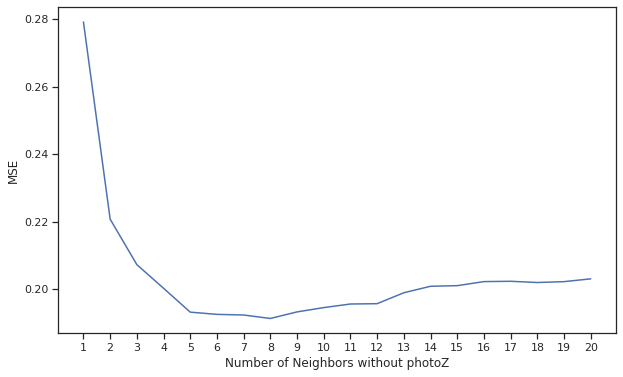

In [33]:
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse)
plt.xticks(loc)
plt.xlabel('Number of Neighbors without photoZ')
plt.ylabel('MSE')
plt.show()


In [35]:
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [7,8,9],
                'p' : [1, 2]
             }

knr = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR = knr.fit(X_train, y_train)

In [36]:
KNR.best_params_

{'algorithm': 'auto',
 'leaf_size': 3,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [37]:
# fit the model and predict the class
y_pred_knr = KNR.predict(X_test)

In [85]:
mse_KNR_all = mean_squared_error(y_test,y_pred_knr)
print('Mean Square Error KNN:', round(mse_KNR_all, 3))

Mean Square Error KNN: 0.182


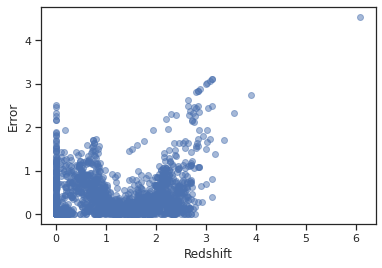

In [40]:
errors = abs(y_pred_knr - y_test)
plt.scatter(y_test, errors, alpha=0.5)
plt.xlabel('Redshift')
plt.ylabel('Error')
plt.show()

In [41]:
data_low = data_cl.loc[(data_cl['z'] <= 1.0 )]
data_low.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2319,18.70122,18.31729,18.24332,18.30030,18.15168,0.754905,2
448,20.12084,17.68555,16.76403,16.46831,16.33418,0.000144,1
1638,19.21249,17.35924,16.38363,15.84537,15.43789,0.086278,3
551,19.17308,17.90121,17.21264,16.82657,16.62209,0.158304,3
2888,17.70881,15.80858,14.93589,14.52878,14.21843,0.051158,3


In [43]:
X =data_low.drop(['nClass', 'z'], axis=1)
y = data_low['z']
# Using RobustScaler to scale the dataset
X_t_low = scaler.fit_transform(X)
X_scaled_low = pd.DataFrame(X_t_low, columns = X.columns)

Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_scaled_low, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xl_train["dered_u"].count()}')
print(f'Count of X_test = {Xl_test["dered_u"].count()}')


Count of X_train = 7997
Count of X_test = 3428


In [44]:
n= 20
mse_low = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xl_train,yl_train)
    yhat= knn.predict(Xl_test)
    mse_low[i-1] = mean_squared_error(yl_test, yhat)

mse_low

array([0.00954656, 0.0082164 , 0.00810261, 0.00815755, 0.00807495,
       0.00814525, 0.00842481, 0.00847053, 0.00852699, 0.00869638,
       0.00870999, 0.00884579, 0.00900773, 0.00919697, 0.00923524,
       0.00945923, 0.00950318, 0.00958003, 0.00962252, 0.00974422])

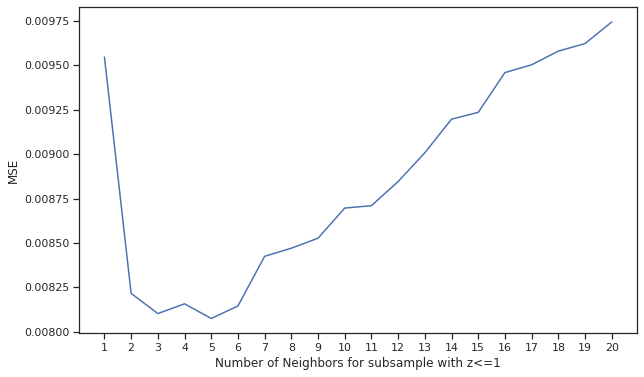

In [45]:
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_low)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample with z<=1')
plt.ylabel('MSE')
plt.show()


In [46]:
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [3, 4, 5],
                'p' : [1, 2]
             }

knr_low = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_low = knr_low.fit(Xl_train, yl_train)

In [47]:
KNR_low.best_params_ ,KNR_low.best_score_

({'algorithm': 'ball_tree',
  'leaf_size': 1,
  'n_neighbors': 5,
  'p': 2,
  'weights': 'distance'},
 0.8433591570154249)

In [60]:
# fit the model and predict the class
yl_pred_knr = KNR_low.predict(Xl_test)

In [84]:
mse_KNR_low = mean_squared_error(yl_test,yl_pred_knr)
print('Mean Square Error KNN for z < 1 :', round(mse_KNR_low, 3))

Mean Square Error KNN for z < 1 : 0.008


In [50]:
data_high = data_cl.loc[(data_cl['z'] > 1.0 )]
data_high.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2890,20.20726,20.07798,19.88147,19.60539,19.84044,1.495903,2
1232,19.00931,18.38472,18.14448,18.13779,17.91815,2.137441,2
4018,18.80096,18.40350,18.24582,18.24194,18.14518,2.146889,2
80,18.23961,18.12419,17.94056,18.06394,18.25757,1.042393,2
2173,19.85457,19.74139,19.78383,19.58776,19.36233,2.089274,2


In [51]:
X = data_high.drop(['nClass', 'z'], axis=1)
y = data_high['z']
# Using RobustScaler to scale the dataset
X_t_high = scaler.fit_transform(X)
X_scaled_high = pd.DataFrame(X_t_high, columns = X.columns)

Xh_train, Xh_test, yh_train, yh_test = train_test_split(X_scaled_high, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xh_train["dered_u"].count()}')
print(f'Count of X_test = {Xh_test["dered_u"].count()}')


Count of X_train = 2502
Count of X_test = 1073


In [52]:
n= 20
mse_high = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xh_train,yh_train)
    yhat= knn.predict(Xh_test)
    mse_high[i-1] = mean_squared_error(yh_test, yhat)

mse_high

array([0.15777092, 0.10361666, 0.08467073, 0.07989195, 0.07708236,
       0.07523124, 0.07657299, 0.07769411, 0.07662342, 0.07884708,
       0.07914824, 0.07881924, 0.0786905 , 0.07860931, 0.07917172,
       0.07894782, 0.07965134, 0.07983514, 0.08103957, 0.08147181])

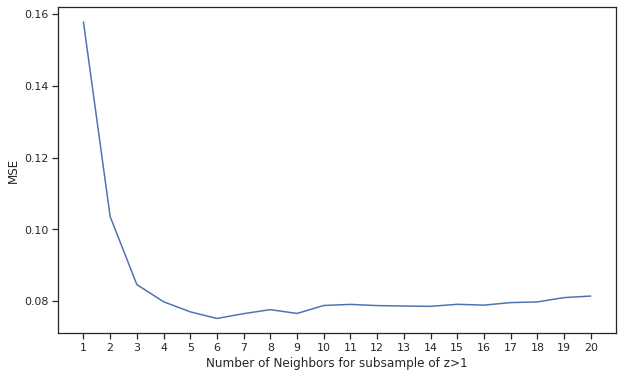

In [53]:
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_high)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample of z>1')
plt.ylabel('MSE')
plt.show()


In [55]:
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [5, 6, 7],
                'p' : [1, 2]
             }

knr_high = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_high = knr_high.fit(Xh_train, yh_train)

In [56]:
KNR_high.best_params_ ,KNR_high.best_score_

({'algorithm': 'auto',
  'leaf_size': 8,
  'n_neighbors': 7,
  'p': 2,
  'weights': 'distance'},
 0.7214160958966193)

In [57]:
# fit the model and predict the class
yh_pred_knr = KNR_high.predict(Xh_test)

In [83]:
mse_KNR_high = mean_squared_error(yh_test,yh_pred_knr)
print('Mean Square Error KNN for z > 1 :', round(mse_KNR_high, 3))

Mean Square Error KNN for z > 1 : 0.075


In [59]:
print(data_cl.loc[(data_cl['z'] > 1.0 )]['z'].count()/data_cl['z'].count()*100)
print(data_cl.loc[(data_cl['z'] <= 1.0 )]['z'].count()/data_cl['z'].count()*100)

23.833333333333336
76.16666666666667


## SVM

In [63]:
from sklearn.svm import SVR
# Use the random grid to search for best hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'sigmoid']} 
  
SVR_grid = GridSearchCV(SVR(), param_grid,  n_jobs = -1)
#SVR_grid = RandomizedSearchCV(SVR(), param_grid,  n_jobs = -1)  
# fitting the model for grid search
svr = SVR_grid.fit(X_train, y_train)

# print best parameter after tuning and best accuracy
svr.best_params_, svr.best_score_

({'kernel': 'rbf', 'gamma': 1, 'C': 10}, 0.6420481254859227)

In [70]:
from sklearn.svm import SVR
# Use the random grid to search for best hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'sigmoid']} 
  
SVR_grid = GridSearchCV(SVR(), param_grid,  n_jobs = -1)
#SVR_grid = RandomizedSearchCV(SVR(), param_grid,  n_jobs = -1)  
# fitting the model for grid search
svr = SVR_grid.fit(X_train, y_train)

# print best parameter after tuning and best accuracy
svr.best_params_, svr.best_score_

({'C': 100, 'gamma': 1, 'kernel': 'rbf'}, 0.6494834653589693)

In [71]:
y_pred_SVR = svr.predict(X_test)
mse_SVR = mean_squared_error(y_test,y_pred_SVR)
print('Mean Square Error SVR:', round(mse_SVR, 3))

Mean Square Error SVR: 0.217


In [72]:
# fitting the model for grid search
svr_low = SVR_grid.fit(Xl_train, yl_train)

# print best parameter after tuning and best accuracy
svr_low.best_params_, svr_low.best_score_

({'C': 10, 'gamma': 1, 'kernel': 'rbf'}, 0.7907746903939541)

In [73]:
yl_pred_SVR = svr_low.predict(Xl_test)
mse_SVR_low = mean_squared_error(yl_test,yl_pred_SVR)
print('Mean Square Error SVR for z<=1:', round(mse_SVR_low, 3))

Mean Square Error SVR for z<=1: 0.009


In [74]:
# fitting the model for grid search
svr_high = SVR_grid.fit(Xh_train, yh_train)

# print best parameter after tuning and best accuracy
svr_high.best_params_, svr_high.best_score_

({'C': 100, 'gamma': 1, 'kernel': 'rbf'}, 0.7292925597813167)

In [75]:
yh_pred_SVR = svr_high.predict(Xh_test)
mse_SVR_high = mean_squared_error(yh_test,yh_pred_SVR)
print('Mean Square Error SVR:', round(mse_SVR_high, 3))

Mean Square Error SVR: 0.075


In [87]:
from tabulate import tabulate
#create data
tab_data = [["All", round(mse_KNR_all, 3), round(mse_SVR, 3)], 
        ["Low",  round(mse_KNR_low, 3),  round(mse_SVR_low, 3)], 
        ["High",  round(mse_KNR_high, 3),  round(mse_SVR_high, 3)]]
  
#define header names
col_names = ["Dataset","KNR", "SVR"]
  
#display table
print(tabulate(data, headers=col_names))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Conclusion

I was able to improve on the accuracy of the SDSS photometric redshift slightly; 0.053 against the 0.068 of the SDSS. Also to note is that the redshift was calculated for all 15000 sources. The SDSS has photometry for 14307 of those 15000.

Using the spectra clasification, the means square error was reduced to 0.034. But using estimated classes yielded an error of 0.089. 

Better estimation of the classes might help reduce the errors on the estimation of redshifts. Also, once since missing from my estimated redshift is an estimation of the errors without the use of the spectral redshift.